### Loading Preprocessed Data

In [1]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.api.models import Sequential, Model
from keras.api.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Concatenate, LSTM, Bidirectional, Dot, Flatten, Layer, Activation, MultiHeadAttention, LayerNormalization
from keras.api.optimizers import Adam, SGD
from keras.api.optimizers.schedules import ExponentialDecay, CosineDecay
from keras.api.callbacks import LearningRateScheduler, Callback, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import math

2024-11-30 07:12:45.226394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732972365.240657  190279 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732972365.244610  190279 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 07:12:45.259653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data from directories
def load_data_from_directory(directory):
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".json"):
                with open(os.path.join(root, file), 'r') as f:
                    entry = json.load(f)
                    data.append((entry["tokens"], entry["label"]))
    return data

# Helper function to load data for a given tokenization method
def load_data_for_method(method):
    train_data = load_data_from_directory(f"vuln_train_{method}") + load_data_from_directory(f"patched_train_{method}")
    test_data = load_data_from_directory(f"vuln_test_{method}") + load_data_from_directory(f"patched_test_{method}")
    
    X_train_full = [entry[0] for entry in train_data]
    y_train_full = [entry[1] for entry in train_data]
    X_test = [entry[0] for entry in test_data]
    y_test = [entry[1] for entry in test_data]
    
    return X_train_full, y_train_full, X_test, y_test

# Set tokenization methods
tokenization_methods = ["basic", "ast", "normalize", "syntax", "cfg"]

# Build vocabulary from training data
def build_vocab(X_train_full):
    """
    Builds a vocabulary from the training data.

    Args:
        X_train_full (list of lists): Tokenized training data.

    Returns:
        dict: Vocabulary mapping tokens to unique IDs.
    """
    vocab = {"<PAD>": 0, "<UNK>": 1}
    current_id = 2

    for sequence in X_train_full:
        for token in (token for sublist in sequence for token in sublist) if isinstance(sequence[0], list) else sequence:
            if token not in vocab:
                vocab[token] = current_id
                current_id += 1
    return vocab

# Normalize nested sequences during token loading
def normalize_sequences(sequences):
    return [
        [token for sublist in sequence for token in sublist] if sequence and isinstance(sequence[0], list) else sequence or ["<UNK>"]
        for sequence in sequences
    ]

# Encode sequences using vocabulary
def encode_sequences(sequences, vocab, max_length):
    unk_id = vocab["<UNK>"]
    encoded = []
    for sequence in sequences:
        encoded_sequence = [vocab.get(token, unk_id) for token in sequence]
        if len(encoded_sequence) > max_length:
            encoded_sequence = encoded_sequence[:max_length]
        else:
            encoded_sequence += [vocab["<PAD>"]] * (max_length - len(encoded_sequence))
        encoded.append(encoded_sequence)
    return np.array(encoded)


### Defining CNN Model

In [3]:
# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim

    def call(self, inputs):
        seq_length = tf.shape(inputs)[1]
        position = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, self.embedding_dim, 2, dtype=tf.float32) * -(np.log(10000.0) / self.embedding_dim))
        positional_encoding = tf.concat([tf.sin(position * div_term), tf.cos(position * div_term)], axis=1)
        positional_encoding = positional_encoding[tf.newaxis, ...]
        return inputs + positional_encoding[:, :seq_length, :]

# Transformer Encoder Layer
def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout_rate):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

    ff_output = Dense(ff_dim, activation="relu")(attention)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# Build the CNN-BiLSTM Model
def build_cnn_model(vocab_size, embedding_dim=256, num_filters=256, kernel_sizes=[3, 5, 7],
                    lstm_units=256, dense_units=256, dropout_rate=0.5, l2_lambda=0.01, num_heads=4):
    input_layer = Input(shape=(None,), dtype="int32")
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(input_layer)
    
    positional_encoding = PositionalEncoding(embedding_dim=embedding_dim)(embedding)
    transformer = transformer_encoder(positional_encoding, num_heads=num_heads, key_dim=embedding_dim, ff_dim=512, dropout_rate=0.1)
    
    conv_layers = []
    for kernel_size in kernel_sizes:
        conv = Conv1D(filters=num_filters, kernel_size=kernel_size, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(transformer)
        pooled = GlobalMaxPooling1D()(conv)
        conv_layers.append(pooled)
    
    conv_features = Concatenate()(conv_layers)
    lstm = Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)))(transformer)
    
    attention = Dense(1, activation="tanh")(lstm)
    attention = Flatten()(attention)
    attention_weights = tf.keras.layers.Activation("softmax")(attention)
    attention_output = tf.keras.layers.Dot(axes=1)([attention_weights, lstm])
    
    combined = Concatenate()([conv_features, attention_output])
    dense = Dense(dense_units, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(combined)
    dropout = Dropout(dropout_rate)(dense)
    output = Dense(1, activation="sigmoid")(dropout)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    return model


### Testing Learning Rates

In [4]:
# # Define the exponential decay learning rate schedule
# def exponential_decay_schedule():
#     return ExponentialDecay(
#         initial_learning_rate=1e-3,
#         decay_steps=1000,
#         decay_rate=0.96,
#         staircase=True
#     )

# # Define the warmup with cosine decay learning rate schedule
# def warmup_cosine_decay_schedule(epoch):
#     if epoch < 5:  # Warmup phase
#         return float(1e-5 + (epoch / 5) * (1e-3 - 1e-5))  # Python float
#     else:  # Cosine decay phase
#         decay = CosineDecay(initial_learning_rate=1e-3, decay_steps=15)
#         return float(decay(epoch - 5))  # Python float

# # Cyclical Learning Rate
# def cyclical_learning_rate_schedule(base_lr=1e-5, max_lr=1e-3, step_size=2000):
#     def lr_schedule(batch):
#         cycle = math.floor(1 + batch / (2 * step_size))
#         x = abs(batch / step_size - 2 * cycle + 1)
#         lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
#         return float(lr)  # Ensure the return value is a Python float
#     return lr_schedule

# # Train with ReduceLROnPlateau
# def train_with_reduce_lr():
#     reduce_lr = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=3,
#         min_lr=1e-6
#     )
#     return None, [reduce_lr]

# # Train with Exponential Decay
# def train_with_exponential_decay():
#     lr_schedule = exponential_decay_schedule()
#     optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
#     return optimizer, []

# # Train with Warmup + Cosine Decay
# def train_with_warmup_cosine_decay():
#     lr_scheduler = LearningRateScheduler(warmup_cosine_decay_schedule)
#     return None, [lr_scheduler]

# # Train with Cyclical Learning Rate
# def train_with_cyclical_lr(base_lr=1e-5, max_lr=1e-3, step_size=2000):
#     lr_schedule = cyclical_learning_rate_schedule(base_lr, max_lr, step_size)
#     lr_scheduler = LearningRateScheduler(lr_schedule)
#     return None, [lr_scheduler]

# # Function to train the model with a specific strategy
# def train_with_strategy(strategy_name, optimizer=None, callbacks=[]):
#     print(f"Training with {strategy_name}...")

#     # Use default SGD optimizer if not provided
#     if not optimizer:
#         optimizer = SGD(learning_rate=0.01, momentum=0.9)

#     # Build and compile the model
#     model = build_cnn_model(vocab_size=vocab_size, embedding_dim=128)
#     model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

#     # Train the model
#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_val, y_val),
#         epochs=10,
#         batch_size=32,
#         callbacks=callbacks,
#         verbose=1
#     )
#     return history

# # Execute strategies
# strategies = {
#     "Cyclical Learning Rate": train_with_cyclical_lr(),
#     "Exponential Decay": train_with_exponential_decay(),
#     "ReduceLROnPlateau": train_with_reduce_lr(),
#     "Warmup + Cosine Decay": train_with_warmup_cosine_decay()
# }

# history_records = {}

# for strategy_name, (optimizer, callbacks) in strategies.items():
#     history = train_with_strategy(strategy_name, optimizer=optimizer, callbacks=callbacks)
#     history_records[strategy_name] = history

# # Plot validation accuracy
# plt.figure(figsize=(10, 6))
# for strategy_name, history in history_records.items():
#     plt.plot(history.history['val_accuracy'], label=strategy_name)
# plt.title("Validation Accuracy by Strategy")
# plt.xlabel("Epochs")
# plt.ylabel("Validation Accuracy")
# plt.legend()
# plt.show()


### Training CNN Using Best Method (so far)

Processing tokenization method: basic


I0000 00:00:1732972367.110017  190279 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6120 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/2


I0000 00:00:1732972373.538649  190359 cuda_dnn.cc:529] Loaded cuDNN version 90300


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.5336 - auc: 0.5271 - loss: 20.7226 - val_accuracy: 0.4390 - val_auc: 0.4760 - val_loss: 18.9039 - learning_rate: 1.0000e-04
Epoch 2/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.4798 - auc: 0.4771 - loss: 18.4365 - val_accuracy: 0.5610 - val_auc: 0.5277 - val_loss: 16.9917 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6602 - auc: 0.4272 - loss: 16.9850  


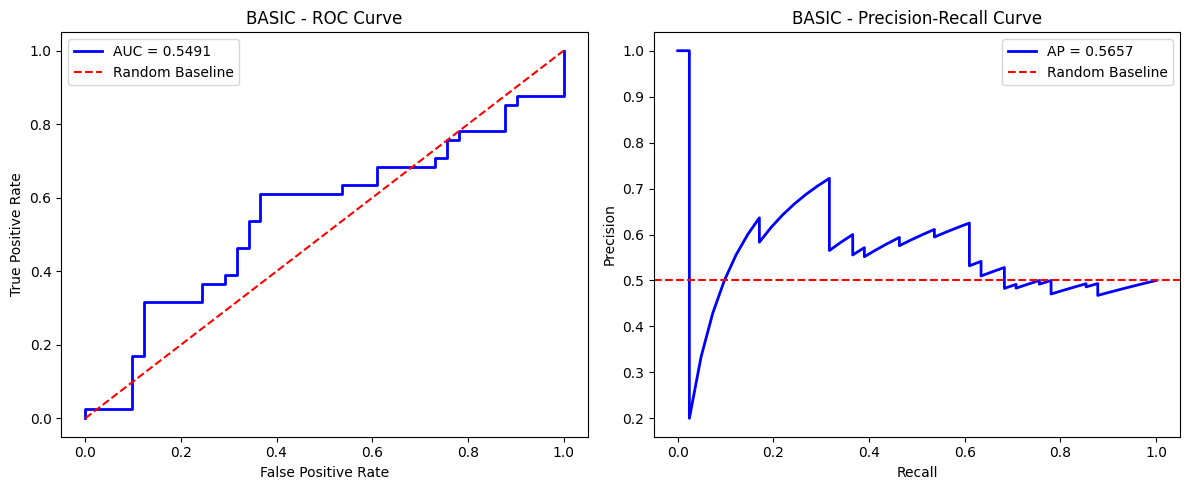

Processing tokenization method: ast
Epoch 1/2


/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.5078 - auc: 0.4892 - loss: 20.7292 - val_accuracy: 0.4421 - val_auc: 0.5015 - val_loss: 18.7911 - learning_rate: 1.0000e-04
Epoch 2/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.4902 - auc: 0.4860 - loss: 18.3274 - val_accuracy: 0.4390 - val_auc: 0.5000 - val_loss: 16.8254 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3398 - auc: 0.3818 - loss: 16.8344      


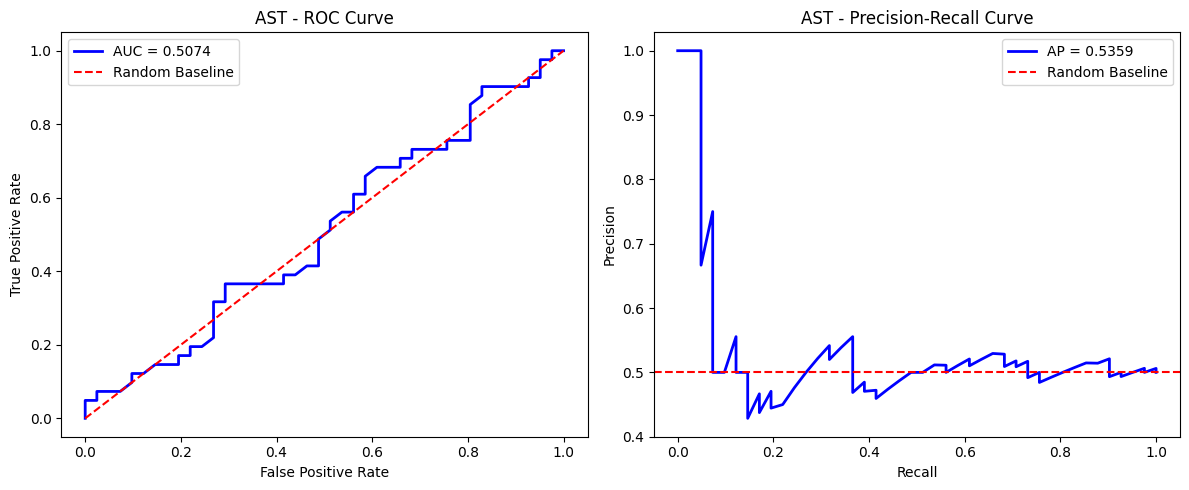

Processing tokenization method: normalize
Epoch 1/2


/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'positional_encoding_2' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.5313 - auc: 0.5275 - loss: 20.5917 - val_accuracy: 0.4390 - val_auc: 0.5238 - val_loss: 18.7885 - learning_rate: 1.0000e-04
Epoch 2/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.5096 - auc: 0.4819 - loss: 18.3322 - val_accuracy: 0.4482 - val_auc: 0.5011 - val_loss: 16.8627 - learning_rate: 1.0000e-04
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step WARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x744db42b5120> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.t

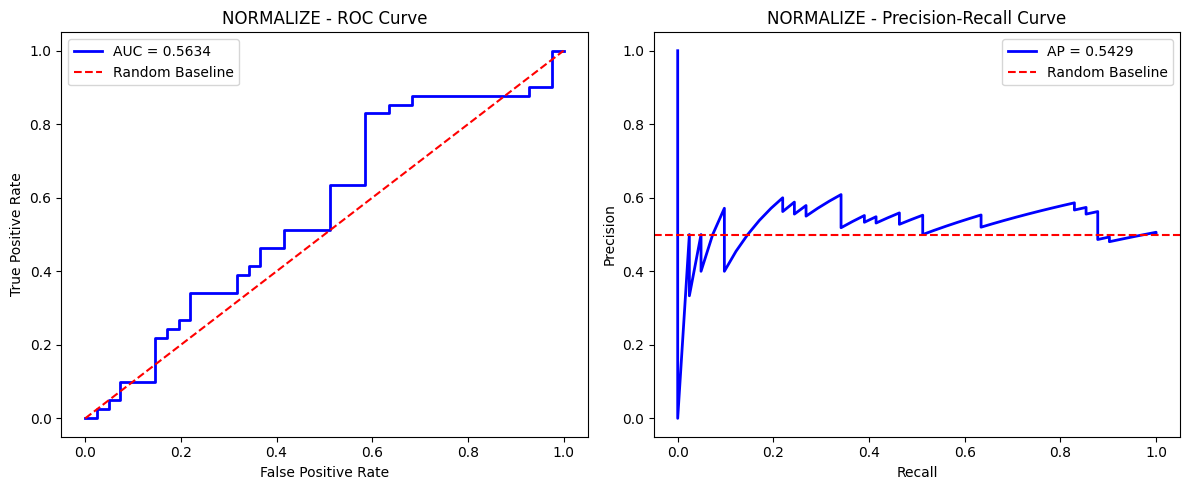

Processing tokenization method: syntax
Epoch 1/2


/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'positional_encoding_3' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.4554 - auc: 0.4453 - loss: 20.9262 - val_accuracy: 0.5610 - val_auc: 0.5100 - val_loss: 18.9272 - learning_rate: 1.0000e-04
Epoch 2/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.4773 - auc: 0.4621 - loss: 18.5102 - val_accuracy: 0.4390 - val_auc: 0.4946 - val_loss: 17.1037 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3398 - auc: 0.3750 - loss: 17.1120      


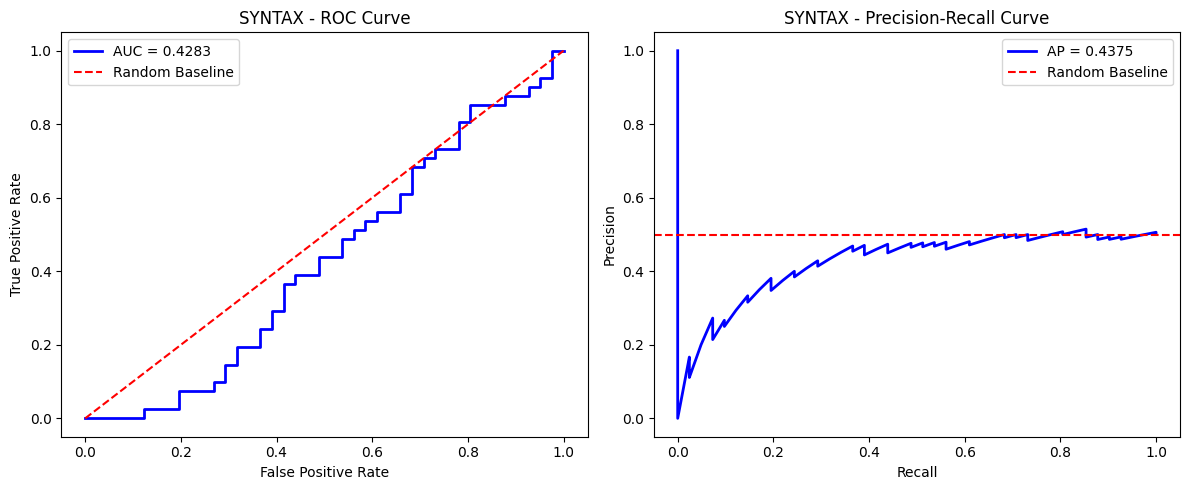

Processing tokenization method: cfg
Epoch 1/2


/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'positional_encoding_4' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.5183 - auc: 0.5175 - loss: 20.7123 - val_accuracy: 0.5610 - val_auc: 0.4440 - val_loss: 18.8438 - learning_rate: 1.0000e-04
Epoch 2/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.5332 - auc: 0.5151 - loss: 18.4246 - val_accuracy: 0.5610 - val_auc: 0.4850 - val_loss: 17.0043 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6602 - auc: 0.3611 - loss: 17.0013  


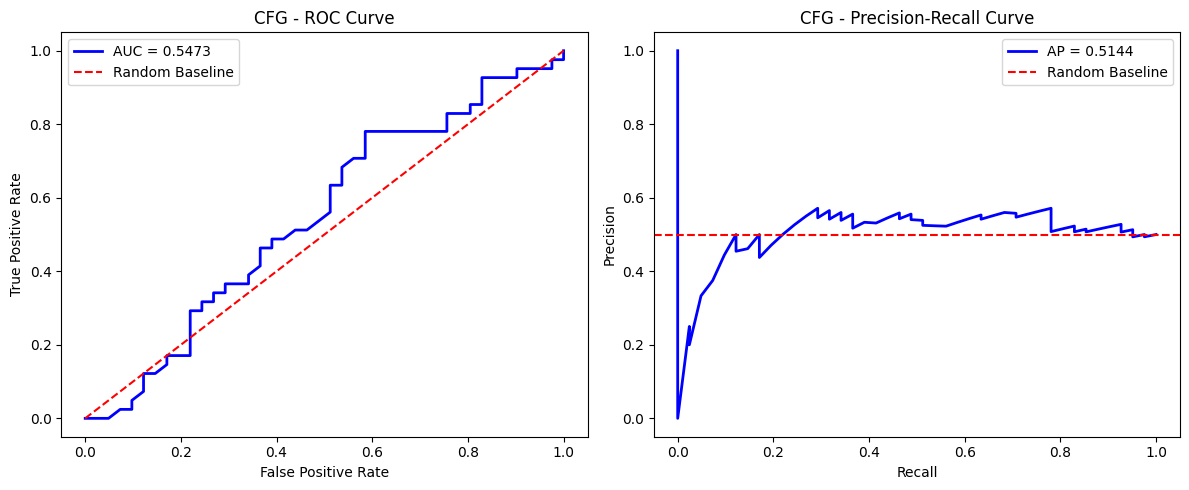

In [5]:
for method in tokenization_methods:
    print(f"Processing tokenization method: {method}")
    
    # Load data
    X_train_full, y_train_full, X_test, y_test = load_data_for_method(method)
    
    X_train_full = normalize_sequences(X_train_full)
    X_test = normalize_sequences(X_test)

    # Build vocabulary
    vocab = build_vocab(X_train_full)
    vocab_size = len(vocab)
    max_length = 512  # Set a fixed maximum sequence length
    
    # Encode sequences
    X_train_full_encoded = encode_sequences(X_train_full, vocab, max_length)
    X_test_encoded = encode_sequences(X_test, vocab, max_length)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full_encoded, 
        np.array(y_train_full), 
        test_size=0.2, 
        random_state=42
    )
    y_test = np.array(y_test)
    
    # Build model
    cnn_model = build_cnn_model(vocab_size=vocab_size)
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    # Train model
    history = cnn_model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val), 
        epochs=2,  # Use more epochs for better results
        batch_size=32, 
        callbacks=[early_stopping, reduce_lr_callback], 
        verbose=1
    )

    # Evaluate model
    y_pred_prob = cnn_model.predict(X_test_encoded, verbose=1)
    test_results = cnn_model.evaluate(X_test_encoded, y_test, verbose=1)
    
    # Compute ROC and PRC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    prc_auc = average_precision_score(y_test, y_pred_prob)

    # Plot ROC Curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='b', lw=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], color='r', linestyle='--', label="Random Baseline")
    plt.title(f"{method.upper()} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    # Plot PRC Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='b', lw=2, label=f"AP = {prc_auc:.4f}")
    plt.axhline(y=0.5, color='r', linestyle='--', label="Random Baseline")
    plt.title(f"{method.upper()} - Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()
